In [16]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer





In [2]:
cik = '0000320193'
headers = {
    'User-Agent': 'mazsikafan@gmail.com'
}
companyfacts = requests.get(f'https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json',headers=headers)


In [3]:
companyfacts.json()['facts']['us-gaap']

{'AccountsPayable': {'label': 'Accounts Payable (Deprecated 2009-01-31)',
  'description': "Carrying value as of the balance sheet date of liabilities incurred (and for which invoices have typically been received) and payable to vendors for goods and services received that are used in an entity's business. For classified balance sheets, used to reflect the current portion of the liabilities (due within one year or within the normal operating cycle if longer); for unclassified balance sheets, used to reflect the total liabilities (regardless of due date).",
  'units': {'USD': [{'end': '2008-09-27',
     'val': 5520000000,
     'accn': '0001193125-09-153165',
     'fy': 2009,
     'fp': 'Q3',
     'form': '10-Q',
     'filed': '2009-07-22',
     'frame': 'CY2008Q3I'},
    {'end': '2009-06-27',
     'val': 4854000000,
     'accn': '0001193125-09-153165',
     'fy': 2009,
     'fp': 'Q3',
     'form': '10-Q',
     'filed': '2009-07-22',
     'frame': 'CY2009Q2I'}]}},
 'AccountsPayableCurre

In [4]:
all_items = []

for key in companyfacts.json()['facts']['us-gaap']:
    # get the 'val' value from the dictionary
    if 'units' in companyfacts.json()['facts']['us-gaap'][key] and 'USD' in companyfacts.json()['facts']['us-gaap'][key]['units']:
        for item in companyfacts.json()['facts']['us-gaap'][key]['units']['USD']:
            if 'val' in item and item.get('form', '') == '10-Q':
                all_items.append((key, item['val'], item.get('filed', 'N/A'), item.get('form', 'N/A')))

df = pd.DataFrame(all_items, columns=['key', 'val', 'filed', 'form'])
df


key           val       filed  form
0                    AccountsPayable  5.520000e+09  2009-07-22  10-Q
1                    AccountsPayable  4.854000e+09  2009-07-22  10-Q
2             AccountsPayableCurrent  5.601000e+09  2010-01-25  10-Q
3             AccountsPayableCurrent  5.601000e+09  2010-04-21  10-Q
4             AccountsPayableCurrent  5.601000e+09  2010-07-21  10-Q
...                              ...           ...         ...   ...
11619      HedgedAssetFairValueHedge  1.510200e+10  2024-02-02  10-Q
11620  HedgedLiabilityFairValueHedge  1.873900e+10  2023-08-04  10-Q
11621  HedgedLiabilityFairValueHedge  1.798600e+10  2023-08-04  10-Q
11622  HedgedLiabilityFairValueHedge  1.824700e+10  2024-02-02  10-Q
11623  HedgedLiabilityFairValueHedge  1.866100e+10  2024-02-02  10-Q

[11624 rows x 4 columns]

In [70]:
df['val'] = df['val'].astype(float)
df['filed'] = pd.to_datetime(df['filed'])
df = df.sort_values(by='filed')
df = df.reset_index(drop=True)


In [71]:

# Isolate the 'NetIncomeLoss' series
net_income_df = df[df['key'] == 'NetIncomeLoss'].copy()

# Make sure the DataFrame is sorted by date
net_income_df.sort_values('filed', inplace=True)

# Reset index for safety
net_income_df.reset_index(drop=True, inplace=True)
net_income_df


key           val      filed  form
0    NetIncomeLoss  3.698000e+09 2009-07-22  10-Q
1    NetIncomeLoss  1.072000e+09 2009-07-22  10-Q
2    NetIncomeLoss  1.229000e+09 2009-07-22  10-Q
3    NetIncomeLoss  4.039000e+09 2009-07-22  10-Q
4    NetIncomeLoss  2.255000e+09 2010-01-25  10-Q
..             ...           ...        ...   ...
141  NetIncomeLoss  7.908200e+10 2023-08-04  10-Q
142  NetIncomeLoss  1.944200e+10 2023-08-04  10-Q
143  NetIncomeLoss  1.988100e+10 2023-08-04  10-Q
144  NetIncomeLoss  2.999800e+10 2024-02-02  10-Q
145  NetIncomeLoss  3.391600e+10 2024-02-02  10-Q

[146 rows x 4 columns]

Cross-validated RMSE scores: [1.02691730e+10 1.08165684e+10 1.27446459e+10 1.49746025e+10
 2.08017297e+10]
Mean RMSE: 13921343883.607977


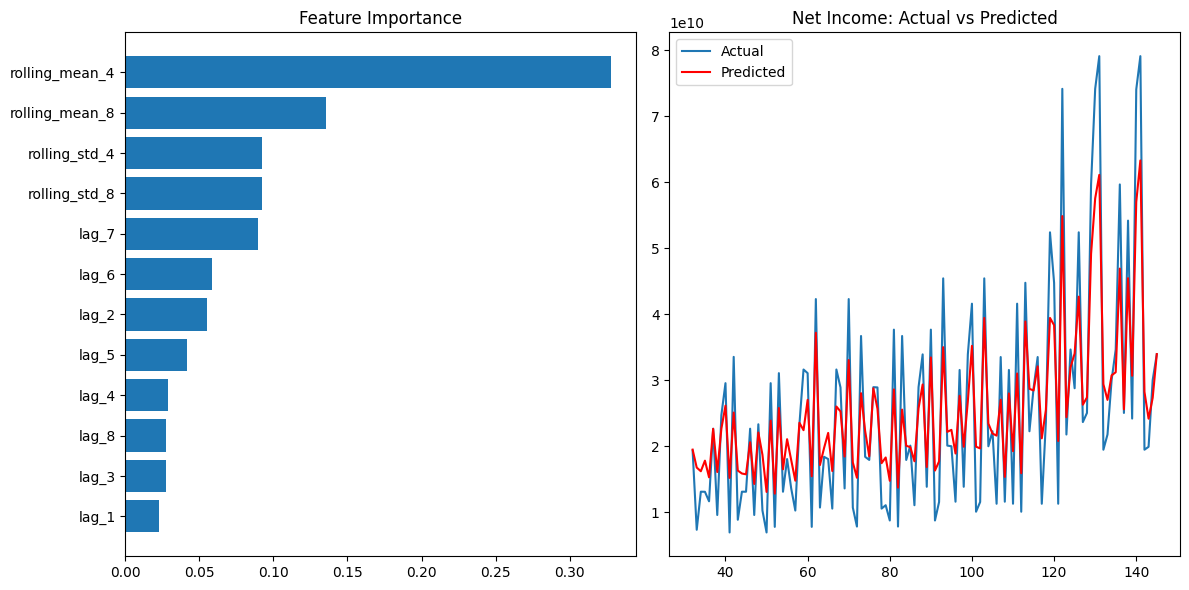

In [72]:
# Assuming net_income_df is your DataFrame after filtering for 'NetIncomeLoss'
# Assuming 'filed' column is already converted to datetime and 'val' to float

# Feature Engineering
# Creating more sophisticated lag features
for lag in range(1, 9):  # Adding more lags to capture a longer history
    net_income_df[f'lag_{lag}'] = net_income_df['val'].shift(lag * 4)  # Quarterly lags

# Add rolling mean and rolling standard deviation as features
window_sizes = [4, 8]  # Quarterly and bi-annual windows
for window in window_sizes:
    net_income_df[f'rolling_mean_{window}'] = net_income_df['val'].rolling(window=window).mean()
    net_income_df[f'rolling_std_{window}'] = net_income_df['val'].rolling(window=window).std()

# Drop rows with NaN values resulting from feature engineering
net_income_df.dropna(inplace=True)

# Prepare features (X) and target (y)
feature_cols = [col for col in net_income_df.columns if 'lag' in col or 'rolling' in col]
X = net_income_df[feature_cols]
y = net_income_df['val']

# Initialize TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Hyperparameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.5, 0.7, 1.0],  # Adding subsample for stochastic gradient boosting
}

# Initialize GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to find the best model
grid_search.fit(X, y)

# Best model after grid search
best_gbr = grid_search.best_estimator_

# Evaluate with cross-validation using the best estimator
cv_scores = cross_val_score(best_gbr, X, y, cv=tscv, scoring='neg_mean_squared_error')

# Calculate and print RMSE scores for each fold
rmse_scores = np.sqrt(-cv_scores)
print(f'Cross-validated RMSE scores: {rmse_scores}')
print(f'Mean RMSE: {rmse_scores.mean()}')

# Plotting the feature importance for better understanding
feature_importance = best_gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(feature_cols)[sorted_idx])
plt.title('Feature Importance')

# Training on the full dataset
best_gbr.fit(X, y)

# Predicting and plotting on the full dataset for a visual comparison
predictions = best_gbr.predict(X)
plt.subplot(1, 2, 2)
plt.plot(net_income_df.index, y, label='Actual')
plt.plot(net_income_df.index, predictions, label='Predicted', color='red')
plt.title('Net Income: Actual vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()



Cross-validated RMSE scores: [0.47986744 0.44830292 0.41418999 0.41260088 0.60730203]
Mean RMSE: 0.47245265252977103


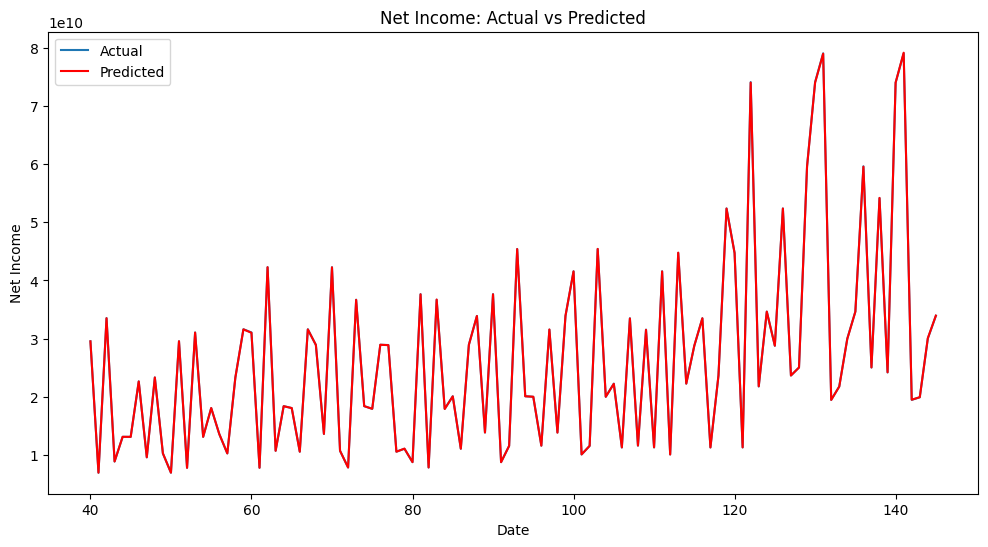

In [73]:



# Assuming net_income_df is your DataFrame after filtering for 'NetIncomeLoss'
# and 'filed' column is already converted to datetime and 'val' to float

# Feature Engineering
# Adding lag features and rolling window statistics
for lag in range(1, 9):
    net_income_df[f'lag_{lag}'] = np.log1p(net_income_df['val'].shift(lag))
    # Using log1p which is log(x + 1) to handle zero values gracefully


# Adding rolling window features
for window in [4, 8]:
    net_income_df[f'rolling_mean_{window}'] = np.log1p(net_income_df['val'].rolling(window=window).mean())
    net_income_df[f'rolling_std_{window}'] = np.log1p(net_income_df['val'].rolling(window=window).std())

# Removing the rows with NaN values after adding new lag and rolling features
net_income_df.dropna(inplace=True)

# Prepare features (X) and target (y)
X = net_income_df[[f'lag_{i}' for i in range(1, 9)] + [f'rolling_mean_{i}' for i in [4, 8]] + [f'rolling_std_{i}' for i in [4, 8]]]
y = np.log1p(net_income_df['val'])  # Log-transforming the target as well

# Initialize TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Bayesian Optimization
search_spaces = {
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(3, 7),
    'learning_rate': Real(0.01, 0.2, 'log-uniform'),
    'subsample': Real(0.5, 1.0)
}

# Initialize GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)

# Set up BayesSearchCV
opt = BayesSearchCV(estimator=gbr, search_spaces=search_spaces, n_iter=32, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)

# Fit BayesSearchCV to find the best model
opt.fit(X, y)

# Best model after optimization
best_gbr = opt.best_estimator_

# Evaluate with cross-validation using the best estimator
cv_scores = cross_val_score(best_gbr, X, y, cv=tscv, scoring='neg_mean_squared_error')

# Calculate and print RMSE scores for each fold
rmse_scores = np.sqrt(-cv_scores)
print(f'Cross-validated RMSE scores: {rmse_scores}')
print(f'Mean RMSE: {rmse_scores.mean()}')

# Training on the full dataset
best_gbr.fit(X, y)

# Predicting and plotting on the full dataset for a visual comparison
predictions = best_gbr.predict(X)
plt.figure(figsize=(12, 6))
plt.plot(net_income_df.index, np.expm1(y), label='Actual')  # Inverse of log1p for actual values
plt.plot(net_income_df.index, np.expm1(predictions), label='Predicted', color='red')  # Inverse of log1p for predicted values
plt.legend()
plt.title('Net Income: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Net Income')
plt.show()



/var/folders/sl/mz3bx1nj3_94rwgrcx6b1pqh0000gn/T/ipykernel_57306/4204915407.py:12: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_dates = pd.date_range(start=last_date, periods=future_periods + 1, freq='Q')[1:]
/var/folders/sl/mz3bx1nj3_94rwgrcx6b1pqh0000gn/T/ipykernel_57306/4204915407.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  net_income_df = pd.concat([net_income_df, future_df])


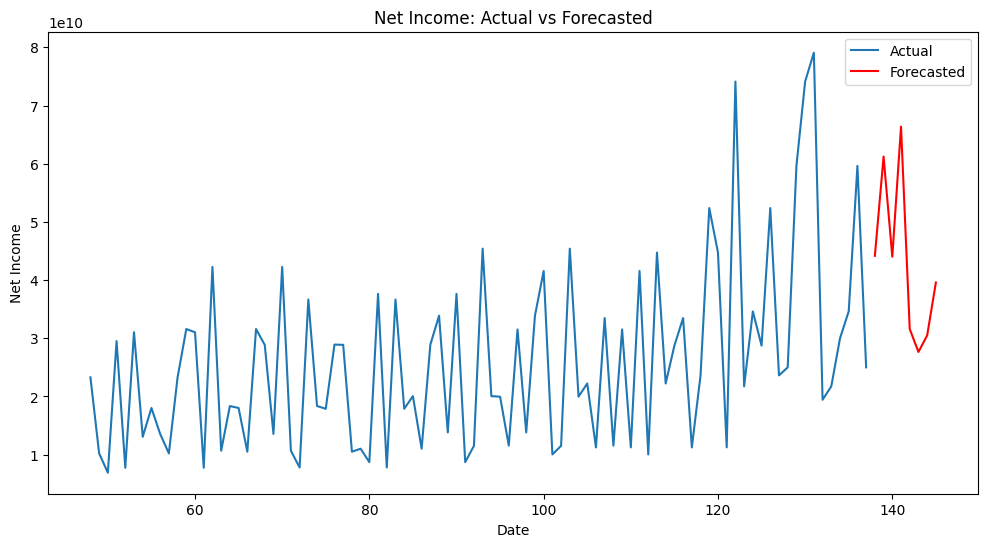

In [75]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import matplotlib.pyplot as plt

# Assuming net_income_df is already prepared and contains 'filed' and 'val' columns up to the current date

# Step 1: Extend net_income_df with future dates
future_periods = 8
last_date = net_income_df['filed'].max()
future_dates = pd.date_range(start=last_date, periods=future_periods + 1, freq='Q')[1:]
future_df = pd.DataFrame(index=future_dates, columns=net_income_df.columns)
future_df['filed'] = future_dates
net_income_df = pd.concat([net_income_df, future_df])

# Step 2: Update DataFrame with lag and rolling features for future dates
for lag in range(1, 9):
    net_income_df[f'lag_{lag}'] = np.log1p(net_income_df['val'].shift(lag))

for window in [4, 8]:
    net_income_df[f'rolling_mean_{window}'] = np.log1p(net_income_df['val'].rolling(window=window).mean())
    net_income_df[f'rolling_std_{window}'] = np.log1p(net_income_df['val'].rolling(window=window).std())

# Ensure all necessary features are calculated before forecasting
net_income_df.dropna(inplace=True)

# Preparing the final feature set for prediction
feature_cols = [f'lag_{i}' for i in range(1, 9)] + [f'rolling_mean_{i}' for i in [4, 8]] + [f'rolling_std_{i}' for i in [4, 8]]
X = net_income_df[feature_cols]
y = np.log1p(net_income_df['val'])

# Splitting X into known and future datasets
X_known, X_future = X[:-future_periods], X[-future_periods:]

# Training the model on known data
model = GradientBoostingRegressor(random_state=42)
model.fit(X_known, y[:-future_periods])

# Forecasting loop for future periods
for i in range(future_periods):
    # Predict the next quarter
    next_val_pred = model.predict(X_future.iloc[i:i+1])
    net_income_df.loc[X_future.iloc[i:i+1].index, 'val'] = np.expm1(next_val_pred)

    # Update future features based on the prediction
    for lag in range(1, 9):
        if i+lag < future_periods:
            net_income_df.loc[X_future.iloc[i+lag:i+lag+1].index, f'lag_{lag}'] = next_val_pred
    
    for window in [4, 8]:
        if i+window < future_periods:
            # Only update rolling means and stds if there are enough future points
            values_to_consider = net_income_df['val'][-(window+i):].dropna()
            if len(values_to_consider) == window:
                rolling_mean_val = np.log1p(values_to_consider.mean())
                rolling_std_val = np.log1p(values_to_consider.std())
                net_income_df.loc[X_future.iloc[i+window:i+window+1].index, f'rolling_mean_{window}'] = rolling_mean_val
                net_income_df.loc[X_future.iloc[i+window:i+window+1].index, f'rolling_std_{window}'] = rolling_std_val

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(net_income_df.index[:-future_periods], np.expm1(y[:-future_periods]), label='Actual')
plt.plot(net_income_df.index[-future_periods:], net_income_df['val'][-future_periods:], label='Forecasted', color='red')
plt.legend()
plt.title('Net Income: Actual vs Forecasted')
plt.xlabel('Date')
plt.ylabel('Net Income')
plt.show()


In [76]:
# print the forecasted values

net_income_forecast = net_income_df['val'][-future_periods:]

# print the forecasted values
print(net_income_df['val'][-future_periods:])


138    4.417665e+10
139    6.123753e+10
140    4.403723e+10
141    6.638392e+10
142    3.159216e+10
143    2.765399e+10
144    3.049944e+10
145    3.959570e+10
Name: val, dtype: float64


In [1]:
# project depreciation with linear regression
# Depreciation & Amortization
depreciation = df[df['key'] == 'Depreciation']['val']
depreciation = depreciation.astype(float)
depreciation = depreciation.reset_index(drop=True)
depreciation = depreciation.dropna()
depreciation = depreciation.reset_index(drop=True)
depreciation = depreciation[depreciation > 0]

depreciation
  

NameError: name 'df' is not defined

In [ ]:
# using linear regression, project the depreciation

from sklearn.linear_model import LinearRegression

# Assuming depreciation_df is your DataFrame after filtering for 'Depreciation'
# and 'filed' column is already converted to datetime and 'val' to float

# Feature Engineering
# Adding lag features and rolling window statistics
for lag in range(1, 9):
    depreciation_df[f'lag_{lag}'] = depreciation_df['val'].shift(lag)
    



